<a href="https://colab.research.google.com/github/jacksonmcl/Federal_Funds_Rate_Model/blob/main/2.%20Data%20Visualization/data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.transforms as mtransforms
from datetime import datetime
from functools import reduce

dfs = {}

In [6]:
dfs['Federal_Funds_Rate'] = pd.read_csv('clean_Federal_Funds_Rate.csv')
dfs['Lagged_FFER'] = pd.read_csv('clean_Lagged_FFR.csv')

# dfs['Reserve_Rate'] = pd.read_csv('clean_Reserve_Rate.csv')
dfs['Discount_Rate'] = pd.read_csv('clean_Discount_Rate.csv')
dfs['Prime_Rate'] = pd.read_csv('clean_Prime_Loan_Rate.csv')

dfs['Consumer_Price_Index'] = pd.read_csv('clean_Consumer_Price_Index.csv')
dfs['Producer_Price_Index'] = pd.read_csv('clean_Producer_Price_Index.csv')
dfs['Personal_Consumption_Expenditure'] = pd.read_csv('clean_Personal_Consumption_Expenditures.csv')
dfs['GDP_Recession_Index'] = pd.read_csv('clean_GDP_Recession_Index.csv')

dfs['Unemployment_Rate'] = pd.read_csv('clean_Unemployment_Rate.csv')
dfs['Mortgage_Rate'] = pd.read_csv('clean_Mortgage_Rate.csv')
dfs['Auto_Loan_Rate'] = pd.read_csv('clean_Auto_Loan_Rate.csv')

target_df = dfs.pop('Federal_Funds_Rate')

# Helper Functions

In [7]:
# This function cleans a dataframe to change datetime to %Y-%m format
def df_dates_monthly(df, Date = 'Date'):
    clean_df = df.copy()
    clean_df[Date] = pd.to_datetime(clean_df[Date])
    clean_df[Date] = clean_df[Date].dt.strftime('%Y-%m')
    return clean_df

In [8]:
def df_change_percent(df, Value = 'Value'):
    clean_df = df.copy()
    clean_df['ChangePercentMonth'] = round(clean_df[Value].pct_change(),6)
    clean_df['ChangePercentYear'] = round(clean_df[Value].pct_change(12),6)
    return clean_df

In [9]:
def plot_comparison(base_df, comparison_df, base_label, comparison_label, Value='Value'):
    base_df = base_df.copy()
    comparison_df = comparison_df.copy()

    base_df.dropna(inplace=True)
    comparison_df.dropna(inplace=True)

    # Convert to Datetime
    base_df['Date'] = pd.to_datetime(base_df['Date'])
    comparison_df['Date'] = pd.to_datetime(comparison_df['Date'])

    # Plot comparison metric
    plt.figure(figsize=(12, 6))
    plt.stackplot(base_df['Date'], base_df[Value], color='lightgray')
    sns.lineplot(x='Date', y=Value, data=comparison_df, label=comparison_label, color='steelblue')

    # Customize plot
    plt.title(f'{base_label} and {comparison_label}')
    plt.xlabel('Date')
    plt.ylabel(f'{comparison_label}')
    plt.grid(True)
    plt.legend()
    plt.show()


# Correlations

In [10]:
for label, df in dfs.items():
  df.drop(columns=['ChangePercentMonth', 'ChangePercentYear'], axis=1, inplace=True)
  df.dropna(inplace=True)
  df.drop_duplicates(inplace=True)

merged_dfs = {k:pd.merge(v, target_df, how='left', on='Date') for (k,v) in dfs.items()}

In [11]:
# Calculate correlations between different variables to Target
corr_list = {
            k:v[['Value_x', 'Value_y']].corr().iat[0,1] # [0,1] is the location on the correlation matrix that has the correlation of Value_x to Value_y
            for (k,v)
            in merged_dfs.items()
        }

# Print correlations of each dataset to Target
print(f'Correlations with The Federal Funds Effective Rate:\n')
for k,v in corr_list.items():
    print(f'\t{k}: {round(v,2)}')

Correlations with The Federal Funds Effective Rate:

	Lagged_FFER: 0.99
	Discount_Rate: 0.97
	Prime_Rate: 0.96
	Consumer_Price_Index: -0.4
	Producer_Price_Index: -0.35
	Personal_Consumption_Expenditure: -0.53
	GDP_Recession_Index: 0.36
	Unemployment_Rate: 0.06
	Mortgage_Rate: 0.92
	Auto_Loan_Rate: 0.92


In [12]:
# Merge the values and plot a pairplot
dataset_list_values = {k:v[['Date', 'Value']] for (k,v) in dfs.items()}
dataset_list_values['Federal_Funds_Rate'] = target_df[['Date', 'Value']]
dataset_list_values.keys()

dict_keys(['Lagged_FFER', 'Discount_Rate', 'Prime_Rate', 'Consumer_Price_Index', 'Producer_Price_Index', 'Personal_Consumption_Expenditure', 'GDP_Recession_Index', 'Unemployment_Rate', 'Mortgage_Rate', 'Auto_Loan_Rate', 'Federal_Funds_Rate'])

In [13]:
merged_values = reduce(lambda left,right: pd.merge(left,right,on='Date', how='outer'), dataset_list_values.values())
merged_values.columns = ['Date'] + list(dataset_list_values.keys())
# sns.pairplot(data = merged_values)

MergeError: Passing 'suffixes' which cause duplicate columns {'Value_x'} is not allowed.

In [ ]:
# Plot a correlation matrix heatmap
f = plt.figure(figsize=(10, 10))
sns.heatmap(merged_values.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

# Graph Visualizations

In [15]:
# Scale Data for Graphing
clean_dfs = {}
for label, df in dfs.items():
  clean_df = df.copy()
  clean_df.columns = ['Date', 'Value']
  clean_dfs[label] = clean_df

## Target Comparison (Value)

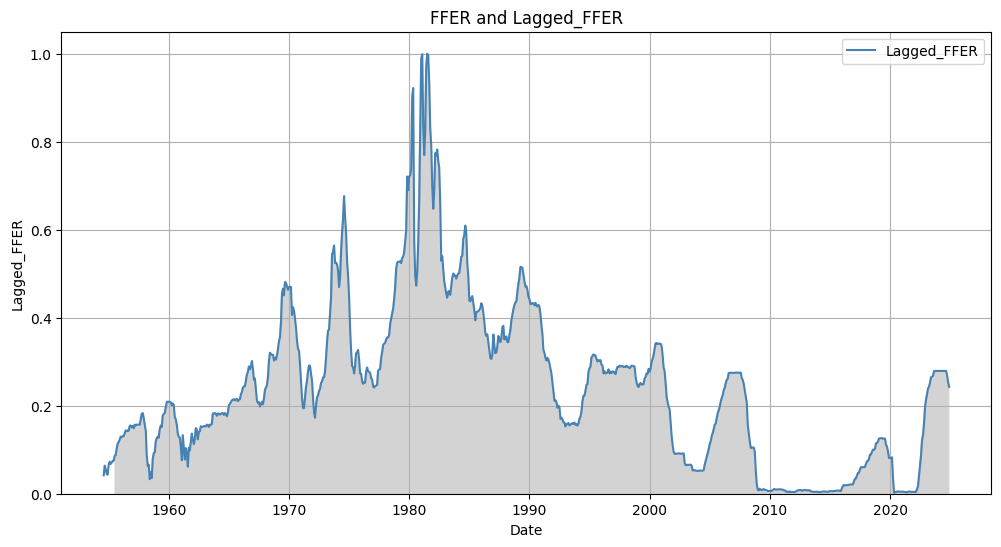

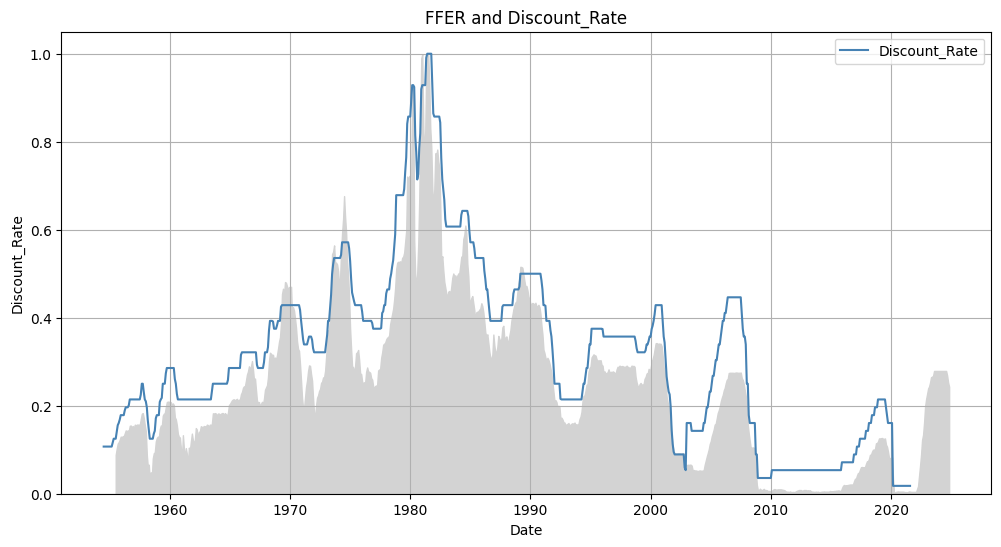

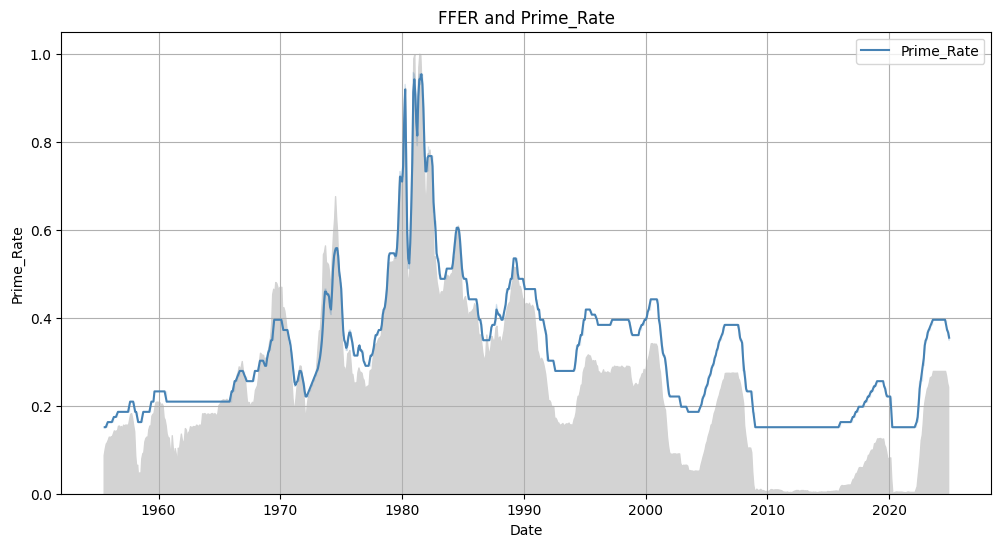

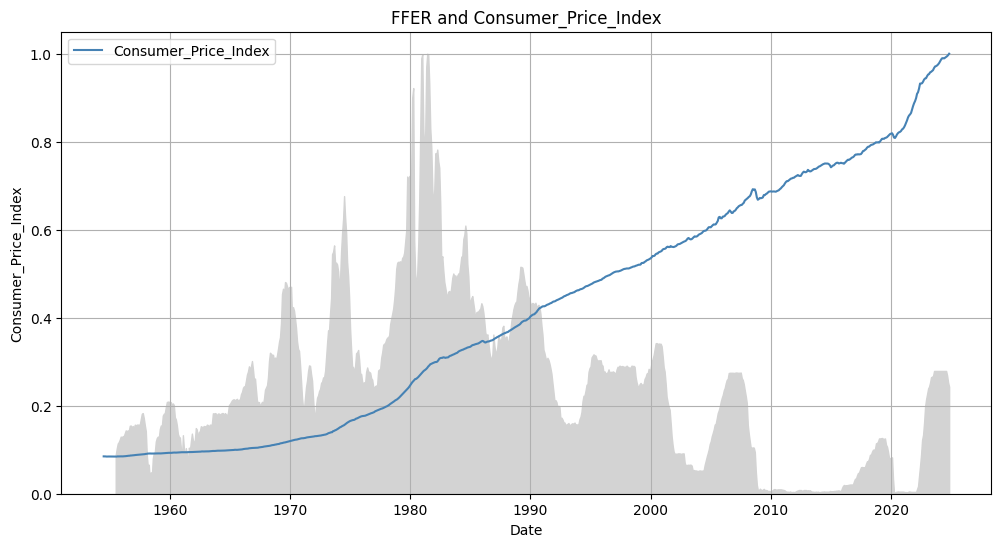

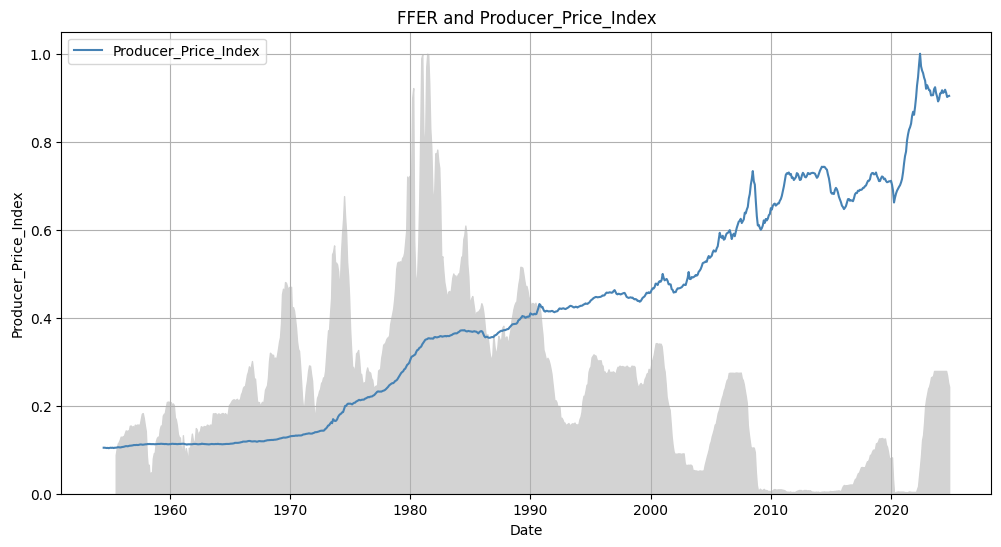

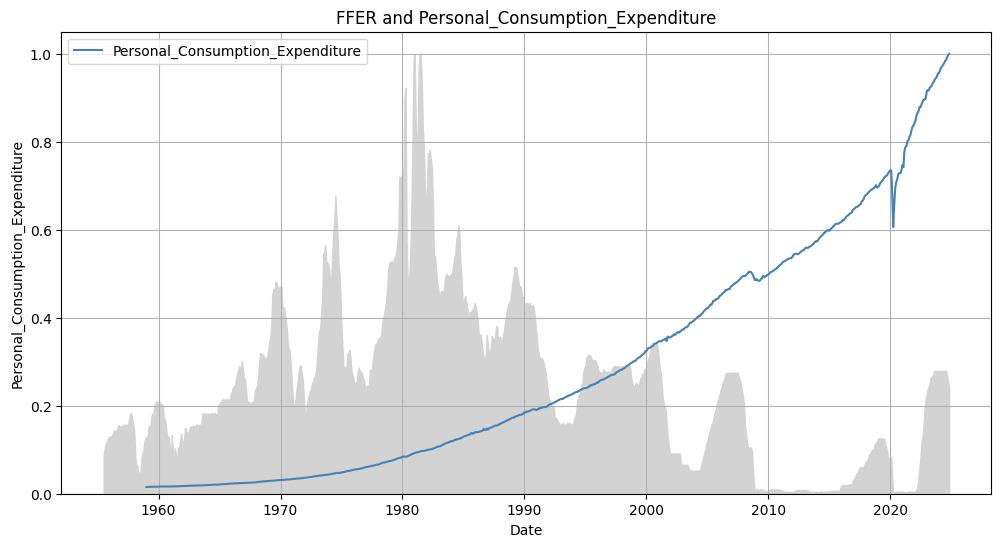

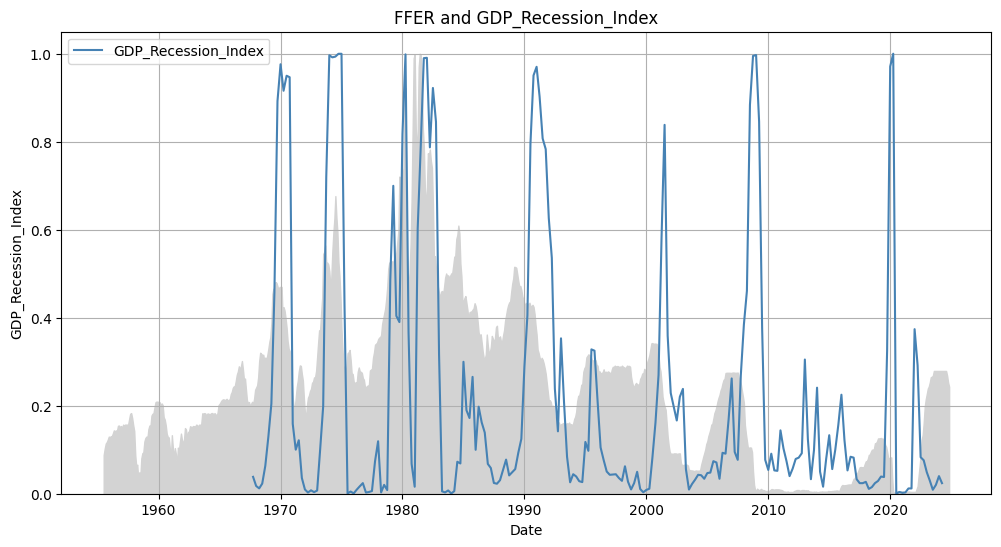

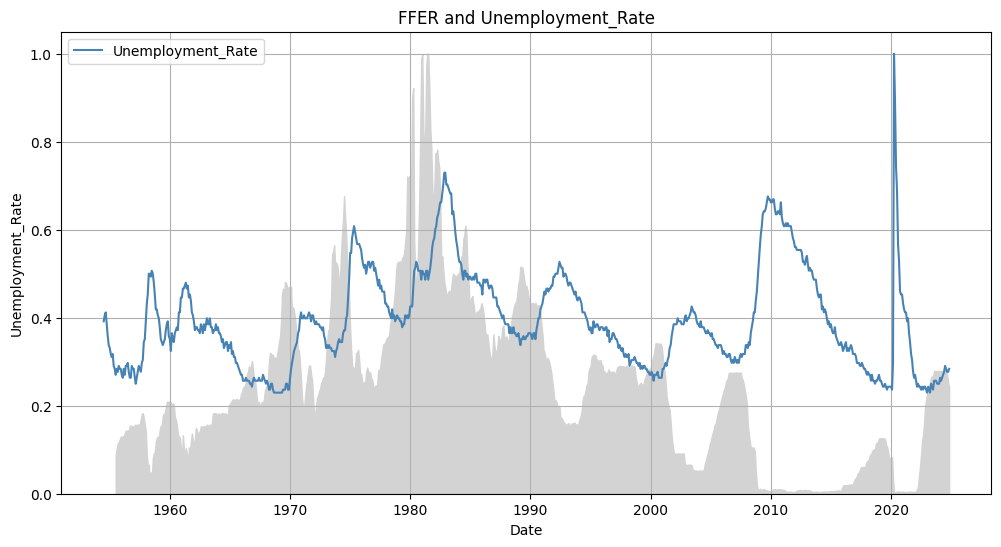

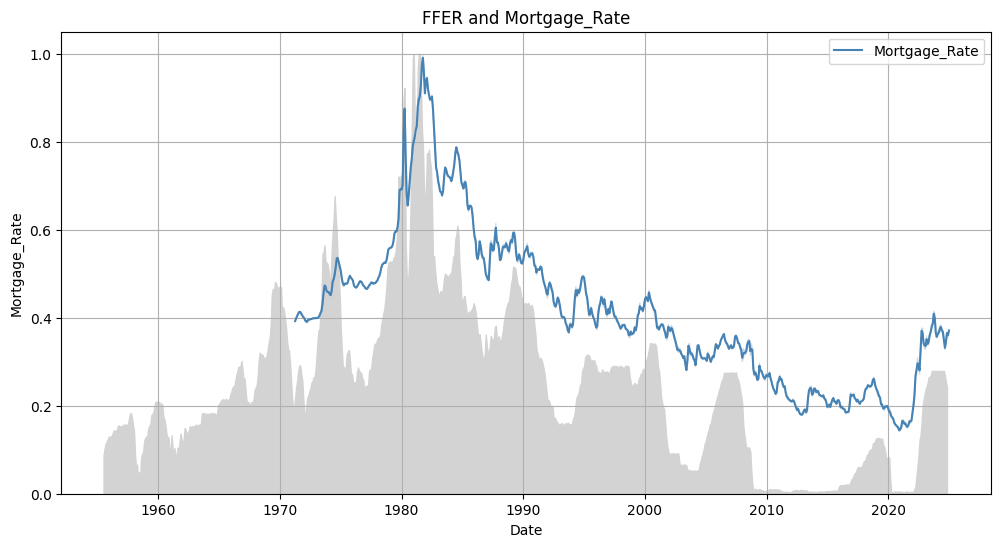

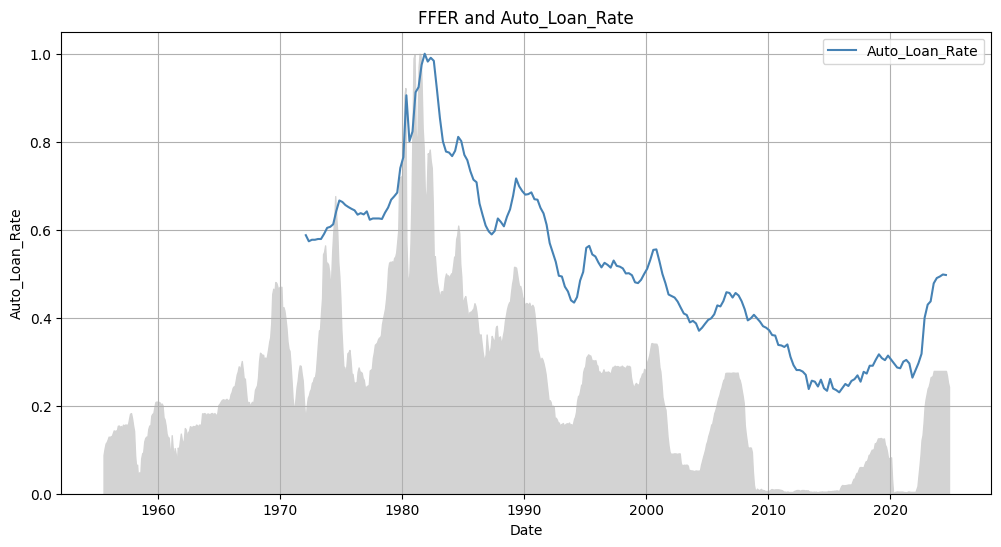

In [16]:
for label, df in clean_dfs.items():
  plot_comparison(target_df, df, 'FFER', label)

## Target Comparison (Monthly)

In [ ]:
for label, df in clean_dfs.items():
  plot_comparison(target_df, df, 'FFER', label, Value='ChangePercentMonth')

## Target Comparison (Annually)

In [ ]:
for label, df in clean_dfs.items():
  plot_comparison(target_df, df, 'FFER', label, Value='ChangePercentYear')